In [1]:
from simple_unet import multi_unet_model #Uses softmax 

from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage.io import imread, imshow
from tqdm import tqdm 



2022-05-26 10:46:30.581733: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-26 10:46:30.581775: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Using TensorFlow backend.


In [3]:
#Resizing images, if needed
SIZE_X = 512
SIZE_Y = 512
n_classes= 3 #Number of classes for segmentation

TRAIN_PATH_X = '/home/khamituly/Documents/Diploma work/big_datasets/common_patients/temp/'
TRAIN_PATH_Y = '/home/khamituly/Documents/Diploma work/big_datasets/common_patients/y/'

#512
# IMG_WIDTH = 512
# IMG_HEIGHT = 512
# IMG_CHANNELS = 3
train_ids_x = next(os.walk(TRAIN_PATH_X))[2]
train_ids_y = next(os.walk(TRAIN_PATH_Y))[2]

In [297]:
# #Capture training image info as a list
# train_images = []

# for directory_path in glob.glob("/home/khamituly/Documents/Diploma work/dataset_manual/new_segmented/x_full"):
#     for img_path in glob.glob(os.path.join(directory_path, "*.jpeg")):
#         img = cv2.imread(img_path, 0)       
#         img = cv2.resize(img, (SIZE_Y, SIZE_X))
#         train_images.append(img)    

# #Convert list to array for machine learning processing        
# train_images = np.array(train_images)

In [298]:
# #Capture mask/label info as a list
# train_masks = [] 
# for directory_path in glob.glob("/home/khamituly/Documents/Diploma work/dataset_manual/new_segmented/y_single_layer"):
#     for mask_path in glob.glob(os.path.join(directory_path, "*.jpeg")):
#         mask = cv2.imread(mask_path, 0)       
#         mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
#         train_masks.append(mask)
        
# #Convert list to array for machine learning processing          
# train_masks = np.array(train_masks)

In [4]:
for n, id_ in enumerate(train_ids_x):
    print(n,id_)
    path = TRAIN_PATH_X + '/'+id_

    img = imread(path)
    # grayscale = rgb2gray(img)
    print(img.shape)

0 2_1.jpg
(494, 508, 3)
1 1_2.jpg
(494, 508, 3)
2 2_4.jpg
(494, 508, 3)
3 2_2.jpg
(494, 508, 3)
4 1_5.jpg
(494, 508, 3)
5 1_1.jpg
(508, 512, 3)
6 1_6.jpg
(494, 508, 3)
7 1_4.jpg
(494, 508, 3)
8 2_3.jpg
(494, 508, 3)
9 1_3.jpg
(494, 508, 3)


In [5]:
train_images = []
train_masks = []

In [6]:
for n, id_ in tqdm(enumerate(train_ids_x), total=len(train_ids_x)):
    #x
    path = TRAIN_PATH_X +id_
    # img = PIL.Image.open(path)
    # image_array = np.array(img)
    # img = imread(path)[:,:,:3]  

    # image_array_x = resize(img, (SIZE_Y, SIZE_X), mode='constant', preserve_range=True)
    img = cv2.imread(path, 0)       
    img = cv2.resize(img, (SIZE_Y, SIZE_X))
    train_images.append(img)

    # y 
    size = len(id_)
    # y_id = id_[:size - 5]
    path_y = TRAIN_PATH_Y+id_

    # img_y = PIL.Image.open(path_y).convert('RGB')
        
    # img_y = imread(path_y)[:,:,:1]
    # img_y = imread(path_y)
    # grayscale_y = rgb2gray(img_y)
    # image_y = np.array(img_y)
    
    mask =  cv2.imread(path_y, 0)  
    mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
    train_masks.append(mask)


train_masks = np.array(train_masks)
train_images = np.array(train_images)

100%|██████████| 10/10 [00:00<00:00, 176.76it/s]


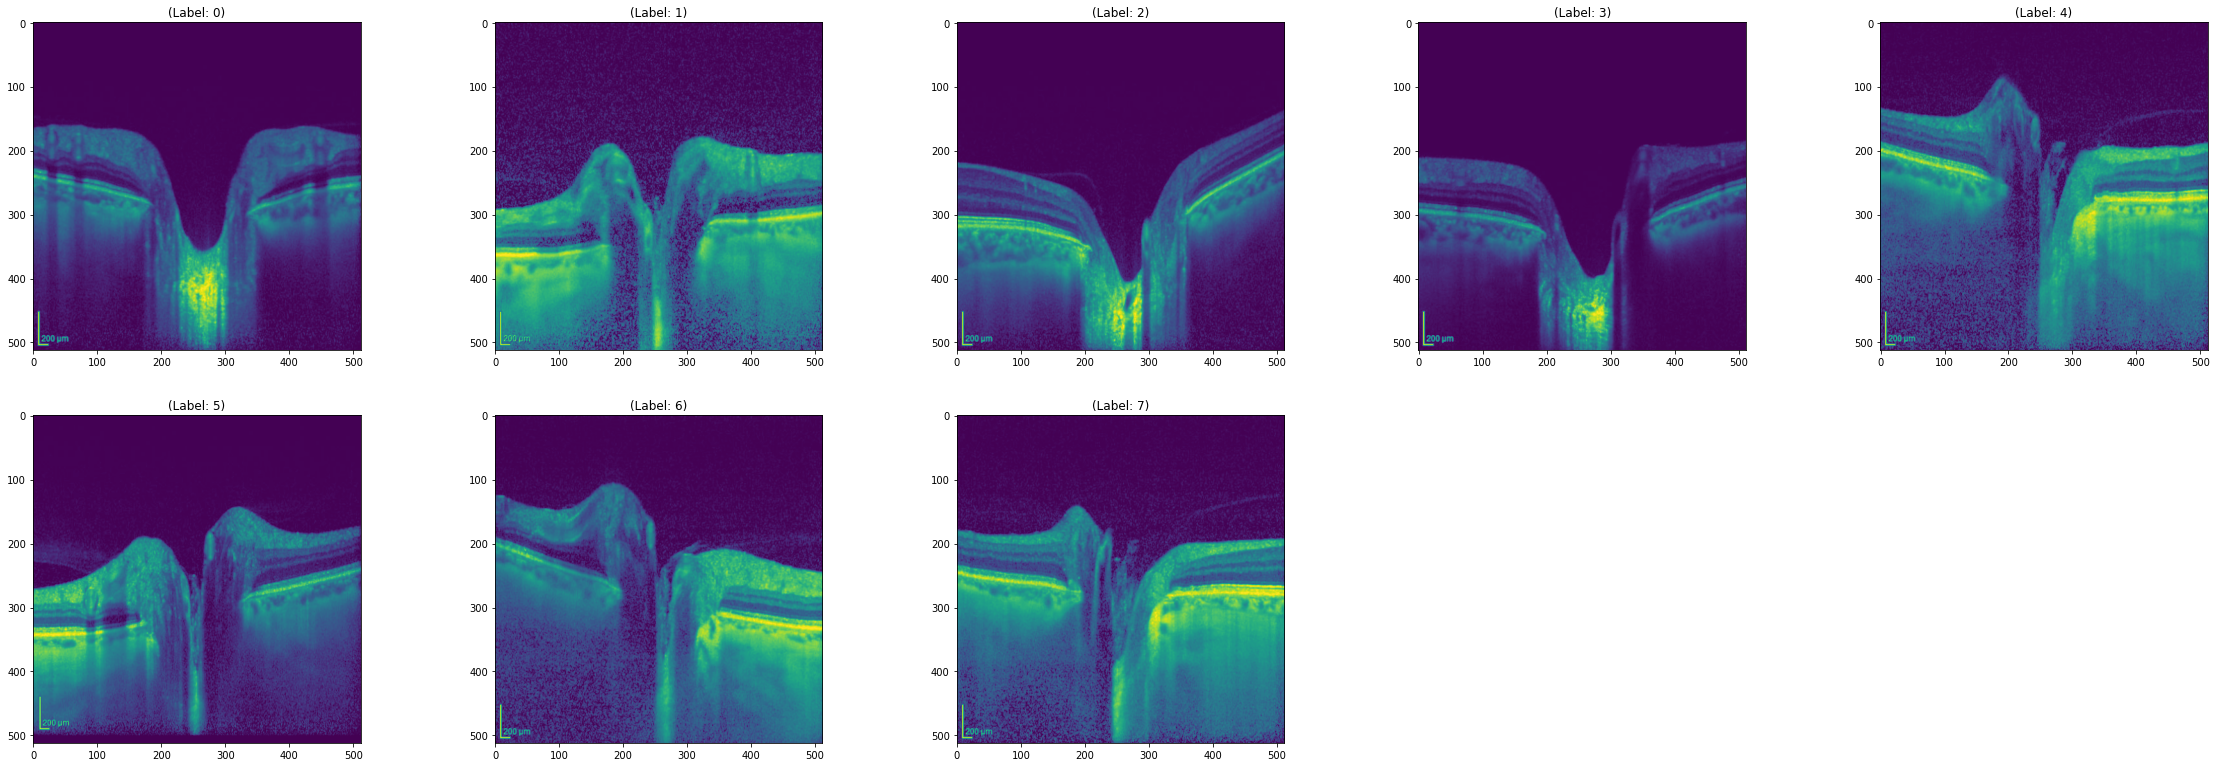

In [7]:
plt.figure(figsize=(40,100))
# print("Оригинал изображений")
for i in range(8):
    plt.subplot(14, 5, i+1)
    plt.imshow(train_images[i,:,:])
    # curr_lbl = X_test[i]
    plt.title("(Label: " + str(i) + ")")
plt.show()   

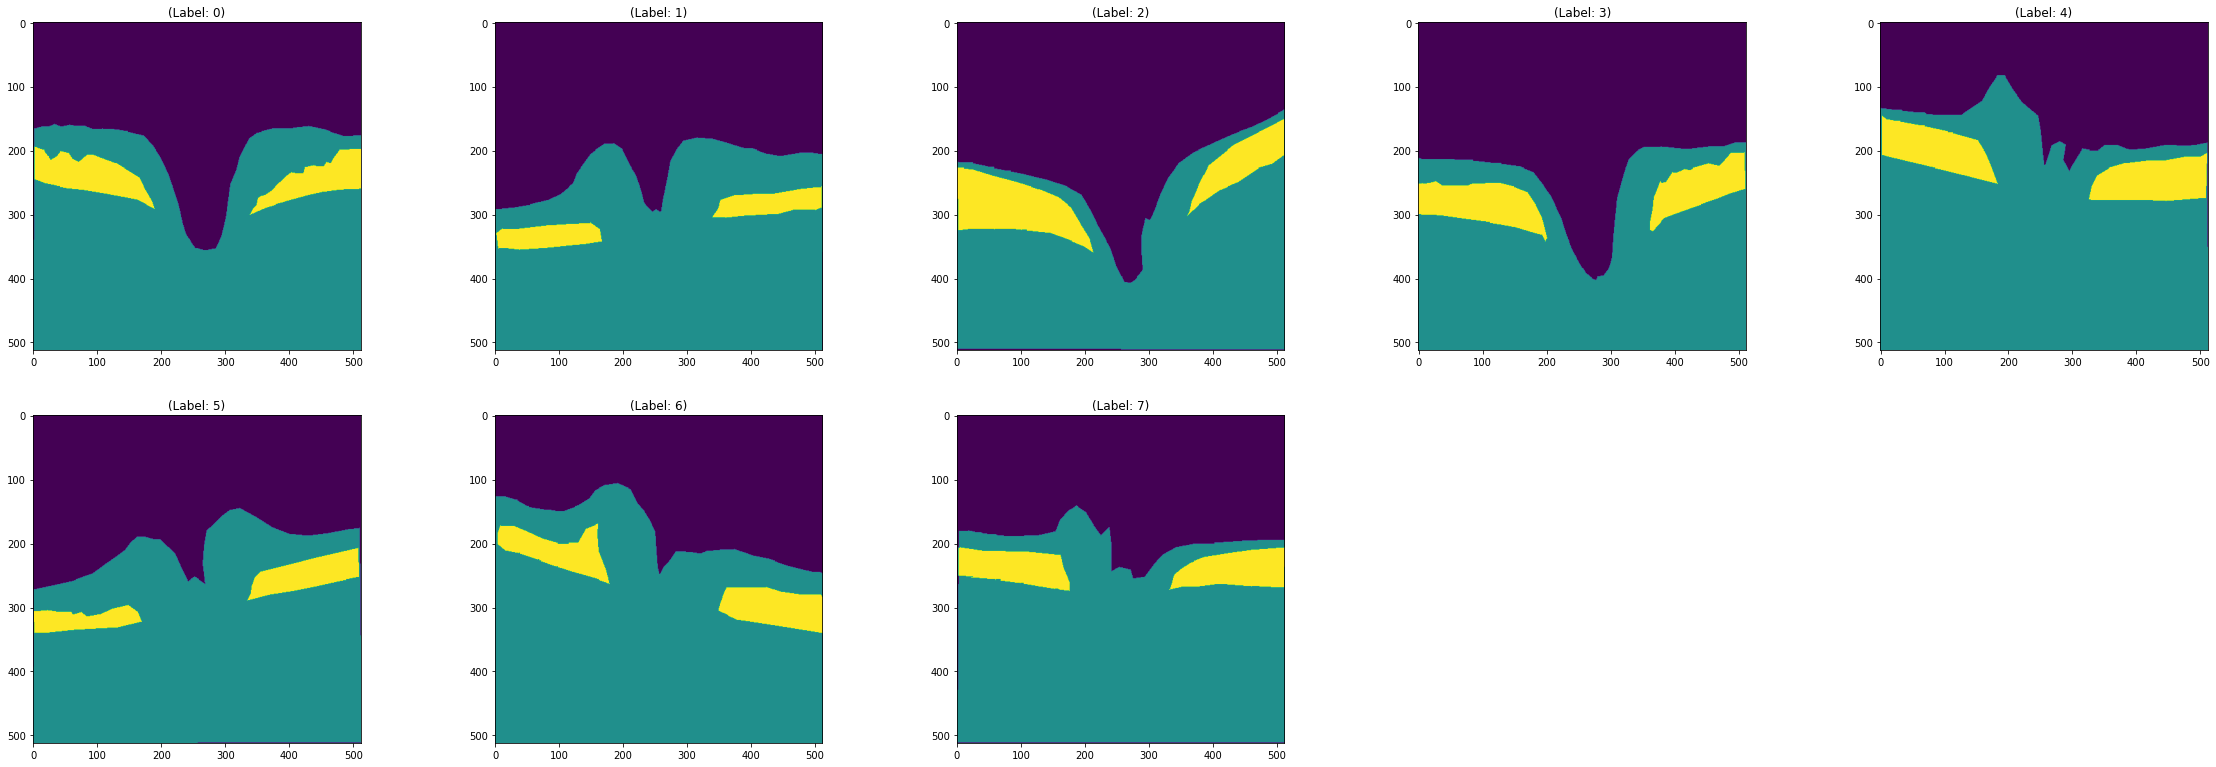

In [8]:
plt.figure(figsize=(40,100))
# print("Оригинал изображений")
for i in range(8):
    plt.subplot(14, 5, i+1)
    plt.imshow(train_masks[i,:,:])
    # curr_lbl = X_test[i]
    plt.title("(Label: " + str(i) + ")")
plt.show()   

In [9]:

###############################################
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)


#################################################
train_images = np.expand_dims(train_images, axis=3)
train_images = normalize(train_images, axis=1)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)


/home/khamituly/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [10]:

#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

#Further split training data t a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.2, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 


Class values in the dataset are ...  [0 1 2]


In [11]:

from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))



test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))



In [12]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_masks_reshaped_encoded),
                                                 train_masks_reshaped_encoded)
print("Class weights are...:", class_weights)

Class weights are...: [0.79166108 0.64582297 5.30725703]


/home/khamituly/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1 2], y=[0 0 0 ... 0 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [13]:

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=SIZE_Y, IMG_WIDTH=SIZE_X, IMG_CHANNELS=1)

model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

2022-05-26 10:47:19.209914: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-26 10:47:19.217185: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-05-26 10:47:19.256687: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-26 10:47:19.256882: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1050 Ti computeCapability: 6.1
coreClock: 1.43GHz coreCount: 6 deviceMemorySize: 3.94GiB deviceMemoryBandwidth: 104.43GiB/s
2022-05-26 10:47:19.256959: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such f

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 512, 512, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 16) 2320        dropout[0][0]                    
______________________________________________________________________________________________

In [14]:

#If starting with pre-trained weights. 
#model.load_weights('???.hdf5')

history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=100, 
                    validation_data=(X_test, y_test_cat), 
                    #class_weight=class_weights,
                    shuffle=False)
                    

# model.save('test.hdf5')
#model.save('sandstone_50_epochs_catXentropy_acc_with_weights.hdf5')
############################################################
#Evaluate the model
	# evaluate model
_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")



2022-05-26 10:47:23.099923: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-26 10:47:23.122379: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3199980000 Hz


Epoch 1/100
1/1 [==============================] - 6s 6s/step - loss: 1.0908 - accuracy: 0.4307 - val_loss: 1.0753 - val_accuracy: 0.4162
Epoch 2/100
1/1 [==============================] - 5s 5s/step - loss: 1.0448 - accuracy: 0.4483 - val_loss: 0.9922 - val_accuracy: 0.4289
Epoch 3/100
1/1 [==============================] - 5s 5s/step - loss: 1.0523 - accuracy: 0.4599 - val_loss: 1.0365 - val_accuracy: 0.5594
Epoch 4/100
1/1 [==============================] - 5s 5s/step - loss: 0.9542 - accuracy: 0.5797 - val_loss: 1.0451 - val_accuracy: 0.8411
Epoch 5/100
1/1 [==============================] - 5s 5s/step - loss: 0.9776 - accuracy: 0.7088 - val_loss: 1.0284 - val_accuracy: 0.8539
Epoch 6/100
1/1 [==============================] - 5s 5s/step - loss: 0.9411 - accuracy: 0.7531 - val_loss: 0.9750 - val_accuracy: 0.8428
Epoch 7/100
1/1 [==============================] - 4s 4s/step - loss: 0.8381 - accuracy: 0.7498 - val_loss: 0.8790 - val_accuracy: 0.8228
Epoch 8/100
1/1 [=================

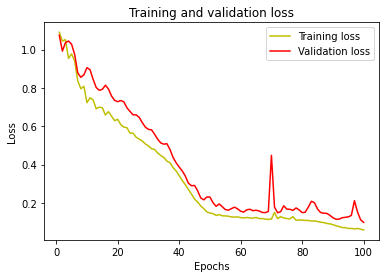

In [15]:


###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

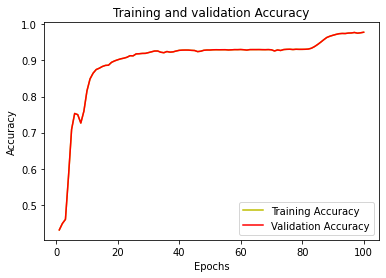

In [17]:

acc = history.history['accuracy']
val_acc = history.history['accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [18]:
##################################
#model = get_model()
# model.load_weights('sandstone_50_epochs_catXentropy_acc.hdf5')  
#model.load_weights('sandstone_50_epochs_catXentropy_acc_with_weights.hdf5')  

#IOU
# X_test = 
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

################

In [19]:

##################################

#Using built in keras function
from keras.metrics import MeanIoU
n_classes = 245
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())



Mean IoU = 0.89853877


[[124396.    892.      0. ...      0.      0.      0.]
 [  2942. 111171.    514. ...      0.      0.      0.]
 [   405.   3716.  18108. ...      0.      0.      0.]
 ...
 [     0.      0.      0. ...      0.      0.      0.]
 [     0.      0.      0. ...      0.      0.      0.]
 [     0.      0.      0. ...      0.      0.      0.]]
IoU for class1 is:  0.9670462937769658
IoU for class2 is:  0.9323688514278525
IoU for class3 is:  0.7962010288880095
IoU for class4 is:  nan


/tmp/ipykernel_18237/3691439479.py:7: RuntimeWarning: invalid value encountered in double_scalars
  class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])


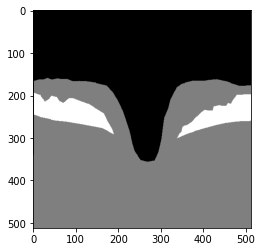

In [20]:
#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

plt.imshow(train_images[0, :,:,0], cmap='gray')
plt.imshow(train_masks[0], cmap='gray')

In [27]:
model.save('retina_segmentation_mentors_dataset.hdf5')

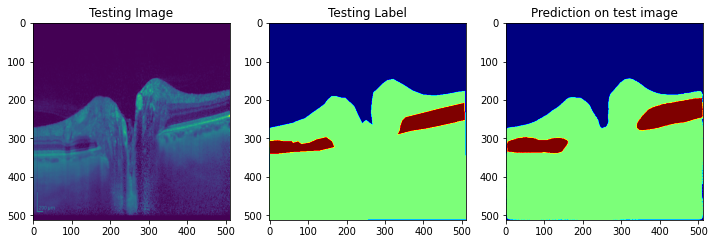

In [21]:
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')  

import random
test_img_number = 2
test_img = X_train[test_img_number]
ground_truth= y_train[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)

prediction = (model.predict(test_img_input))
predicted_img = np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()

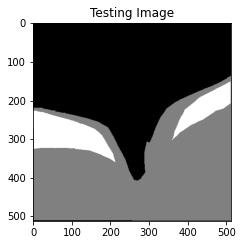

In [22]:
plt.figure(figsize=(20, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(y_test[0,:,:], cmap='gray')

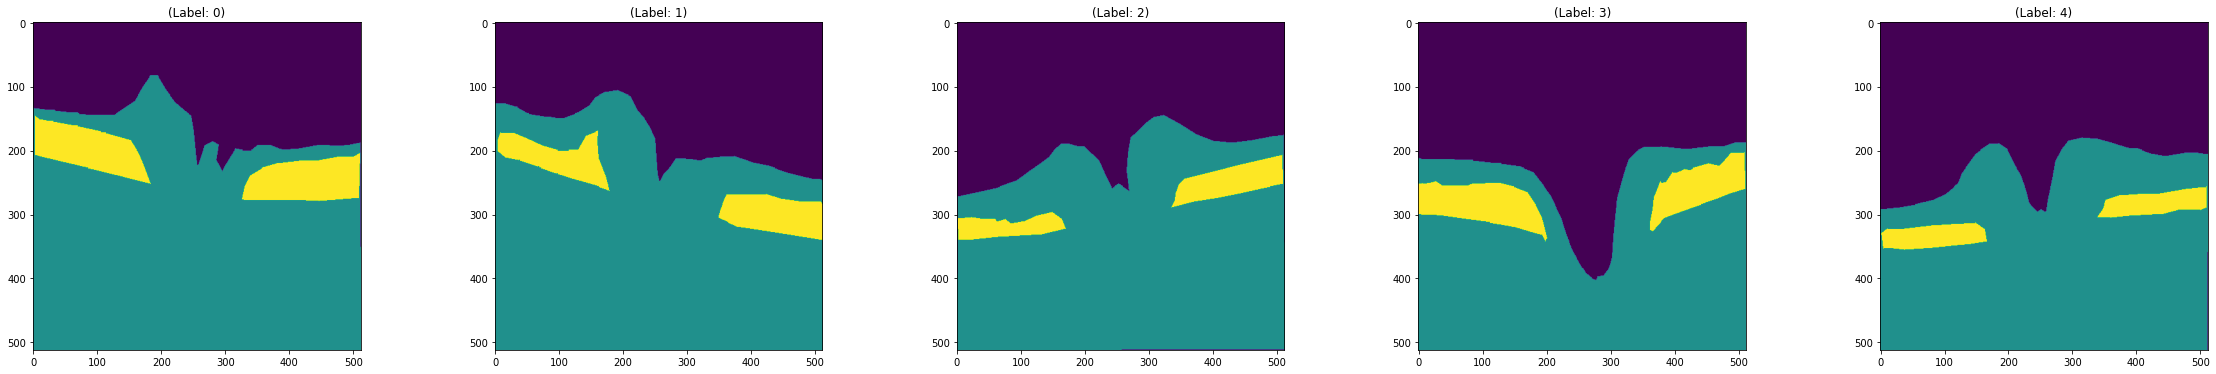

In [23]:
plt.figure(figsize=(40,100))
# print("Оригинал изображений")
for i in range(5):
    plt.subplot(14, 5, i+1)
    plt.imshow(y_train[i,:,:])
    # curr_lbl = X_test[i]
    plt.title("(Label: " + str(i) + ")")
plt.show()   

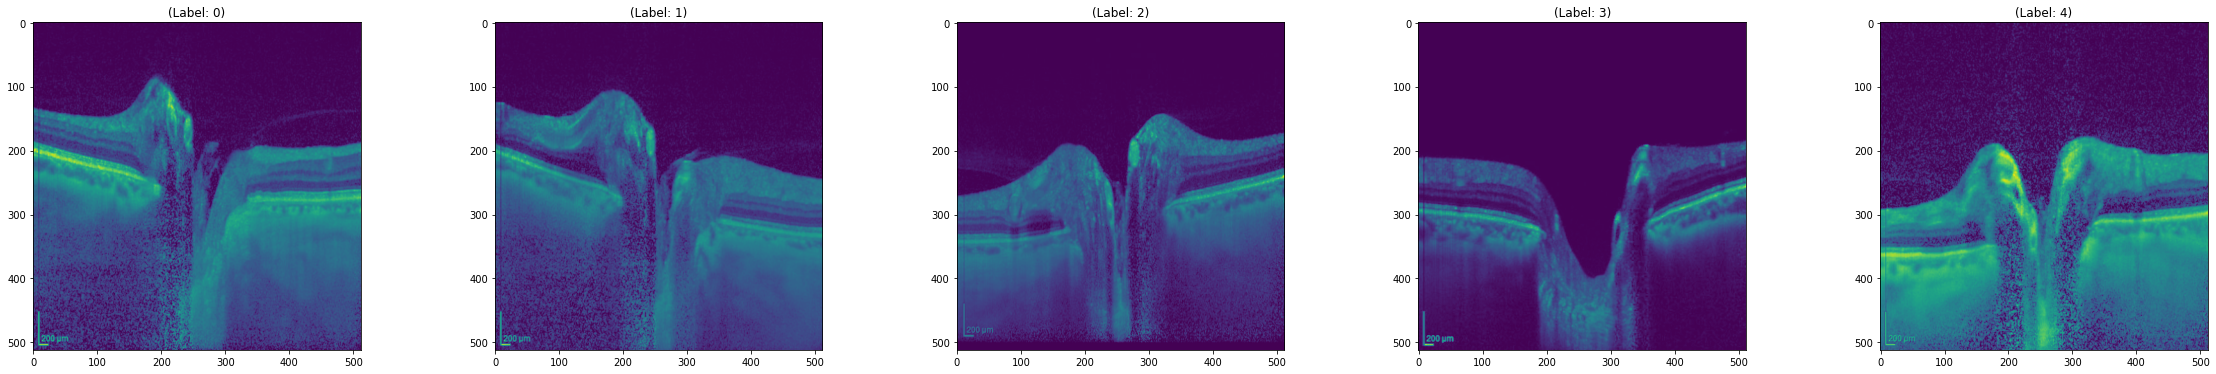

In [24]:
plt.figure(figsize=(40,100))
# print("Оригинал изображений")
for i in range(5):
    plt.subplot(14, 5, i+1)
    plt.imshow(X_train[i,:,:])
    # curr_lbl = X_test[i]
    plt.title("(Label: " + str(i) + ")")
plt.show()   

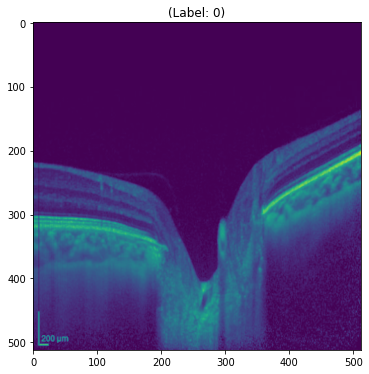

In [25]:
plt.figure(figsize=(40,100))
# print("Оригинал изображений")
for i in range(1):
    plt.subplot(14, 5, i+1)
    plt.imshow(X_test[i,:,:])
    # curr_lbl = X_test[i]
    plt.title("(Label: " + str(i) + ")")
plt.show()   

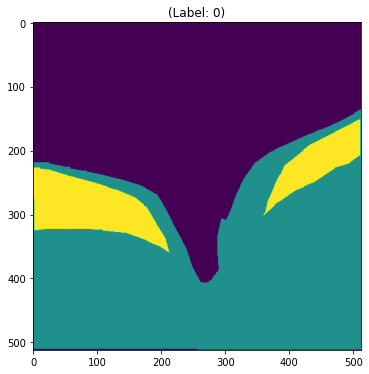

In [26]:
plt.figure(figsize=(40,100))
# print("Оригинал изображений")
for i in range(1):
    plt.subplot(14, 5, i+1)
    plt.imshow(y_test[i,:,:])
    # curr_lbl = X_test[i]
    plt.title("(Label: " + str(i) + ")")
plt.show()   